## Desigualdade De Bell
- Desigualdade de CHSH estabelece um limite máximo para a correlação entre medições locais em dois sistemas separados
- Limite Clássico: $|S|\leq2$
- Limite Quântico: $|S|\leq2\sqrt{2}$

## Desenvolvendo um circuito para violar a Desigualdade de Bell

1. Preparar um estado maximamente emaranhado
$$
\begin{cases} 
\ket{\Phi^{+}} = \frac{1}{\sqrt{2}} (\ket{00}+\ket{11}) \\
\ket{\Phi^{-}} = \frac{1}{\sqrt{2}} (\ket{00}-\ket{11}) \\
\ket{\Psi^{+}} = \frac{1}{\sqrt{2}} (\ket{01}+\ket{10}) \\
\ket{\Psi^{-}} = \frac{1}{\sqrt{2}} (\ket{01}-\ket{10})
\end{cases} 
$$
2. Escolhemos o estado $\ket{\Psi^{-}}$
3. Realizar medições nos qubits em bases escolhidas para maximizar a violação da desigualdade de Bell

In [2]:
#Biblioteca necessárias para construção do algoritmo de CHSH

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from qiskit import *
from qiskit.circuit.library import RYGate
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.primitives import BackendSamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.visualization import plot_histogram


## Mapeamento:
1. Criação do circuito com qubtis emaranhados

$$
\ket{\psi} = \frac{1}{\sqrt{2}} (\ket{00}+\ket{11})
$$
2. Aplicar a porta x e z no qubit 2 para chegar ao estado $\ket{\Psi^{-}}$

$$
\begin{align*}
(Z \otimes I)(X \otimes I) \ket{\psi} 
&= (Z \otimes I)(X \otimes I) \left( \frac{1}{\sqrt{2}} (\ket{00} + \ket{11}) \right) \\
&= (Z \otimes I) \left( \frac{1}{\sqrt{2}} (X\ket{0} \otimes \ket{0} + X\ket{1} \otimes \ket{1}) \right) \\
&= (Z \otimes I) \left( \frac{1}{\sqrt{2}} (\ket{1}\ket{0} + \ket{0}\ket{1}) \right) \\
&= \frac{1}{\sqrt{2}} (Z\ket{1} \otimes \ket{0} + Z\ket{0} \otimes \ket{1}) \\
&= \frac{1}{\sqrt{2}} ((-\ket{1})\ket{0} + \ket{0}\ket{1}) \\
&= \frac{1}{\sqrt{2}} (\ket{0}\ket{1} - \ket{1}\ket{0}) \\
&= \ket{\Psi^-}
\end{align*}
$$

- Para violar CHSH, as medições devem ser feitas em bases rotacionadas. Logo, vamo aplicar duas porta $Ry(\theta)$ -uma em cada qubit- para atingir a violação.
$$
R_y(\theta) = 
\begin{bmatrix}
\cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \\
\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right) 
\end{bmatrix}
$$

- Utilizamos um função que recebe dois parâmetros: theta_a(Ângulo de medição de Alice) e theta_b(Ângulo de medição de Bob) para criação de um circuito. Esse ângulos contribuiem para determinação das bases para qubit que será medido 


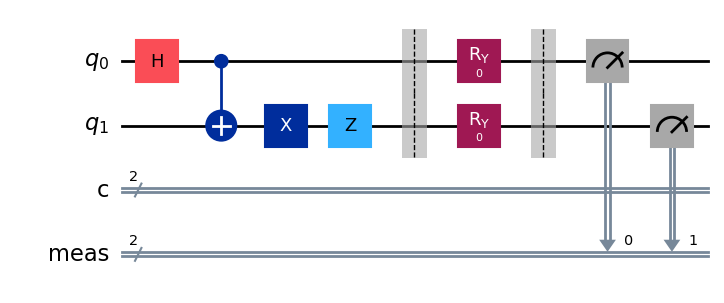

In [3]:
#Função do estado de bell com parametros theta_a e theta_b
def bell_circuit(theta_a, theta_b):
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.x(1)
    qc.z(1)

    qc.barrier()

    #Rotação de um qubit em torno do eixo Y.
    qc.ry(-theta_a, 0) #Rotação de Alice
    qc.ry(-theta_b, 1) #Rotação de Bob
    
    qc.measure_all()
    return qc

# Circuito sem rotação
theta_a = 0
theta_b = 0

circuito = bell_circuit(theta_a, theta_b)
circuito.draw("mpl")

In [4]:
# --- make a copy without the measurements -------------------------
latex = circuito.remove_final_measurements(inplace=False)

# --- get the statevector ------------------------------------------
psi = Statevector.from_instruction(latex)
#print(psi.data)            # raw complex amplitudes

psi.draw(output='latex')          # pretty bra-ket form


<IPython.core.display.Latex object>

## Criação do Backend e Transpilação 
1. Criar um Backend(Com os parâmetros de um computador real da IBM)
2. Criar um modelo de ruído a partir do backend 

In [5]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True,
                             simulator=False,
                             min_num_qubits=50)

noise_model = NoiseModel.from_backend(backend)
print(backend)
backend_simulator = AerSimulator(noise_model=noise_model)
sampler = BackendSamplerV2(backend=backend_simulator)
backend = AerSimulator()

<IBMBackend('ibm_brisbane')>


## Executar circuitos de Bell com diferentes configurações de ângulos e armazenar os resultados das medições.

In [6]:
# Criação do dicionário com ângulos de rotação 
angles = {
    'A0B0': (0,np.pi/4),
    'A0B1': (0,-np.pi/4),
    'A1B0': (np.pi/2,np.pi/4),
    'A1B1': (np.pi/2,-np.pi/4)
}

# Executar os circuitos
results_com_ruido = {} #Inicializa dicionário vazio para armazenar as contagens de cada configuração.
for label, (theta_a, theta_b) in angles.items(): #Itera sobre cada par label e tuplas de ângulos
    qc = bell_circuit(theta_a, theta_b) #Retorna o circuito quântico específico daquela configuração.
    tqc = transpile(qc, backend_simulator) #adapta o circuito para o backend (aqui, o simulador).
    job = backend_simulator.run(tqc, shots=1000) #Executa o circuito transpilado no simulador.
    counts = job.result().get_counts()  # obtém o resultado da execução.
    results_com_ruido[label] = counts #Armazena os resultados no dicionário results, com a chave sendo o rótulo da configuração

## Plotar os histograma de medição

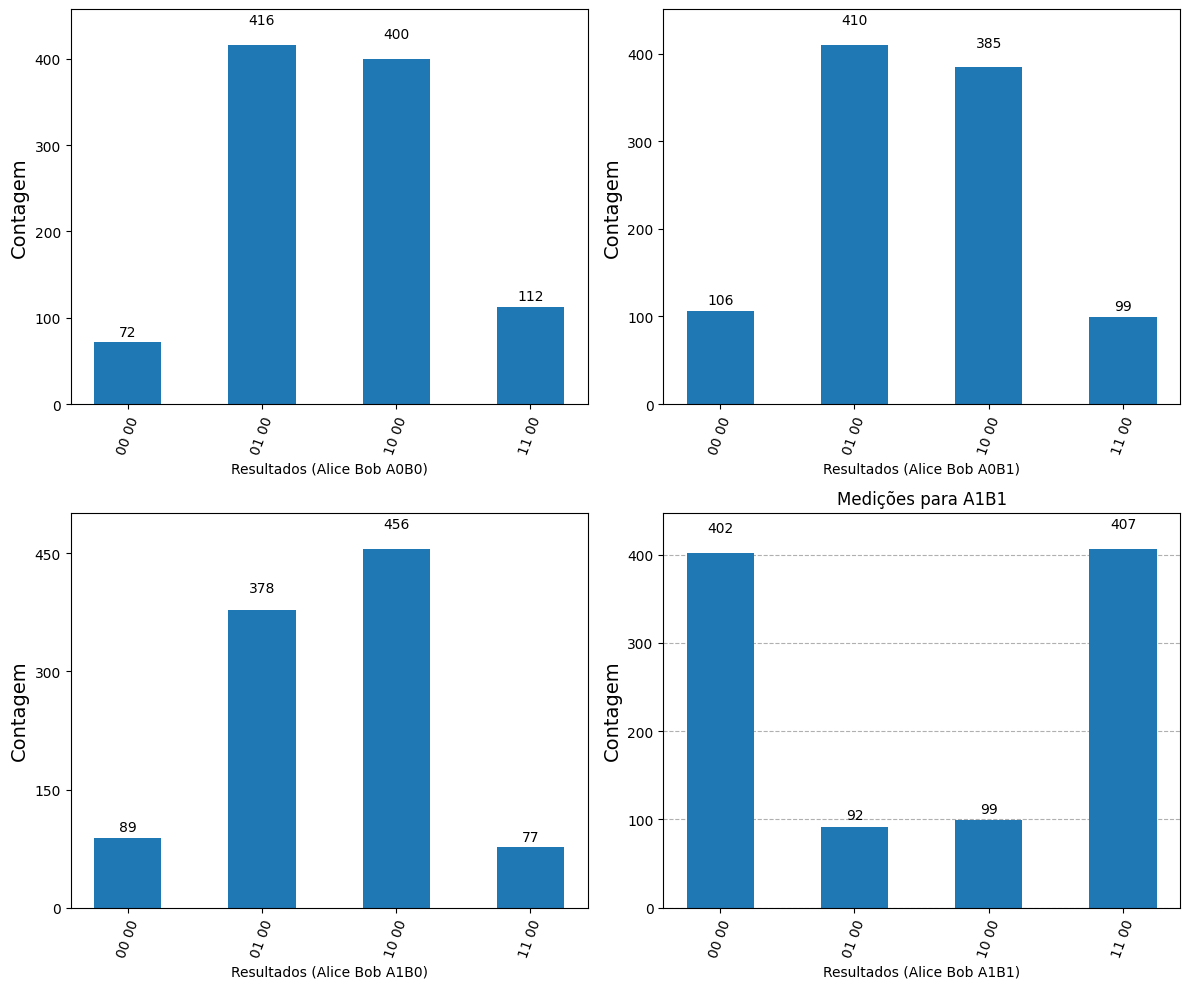

In [7]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

# Criar uma figura com 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Converter os eixos para uma lista simples para facilitar o loop
axs = axs.ravel()

# Para cada configuração de ângulo, gerar o histograma correspondente
for idx, (label, counts) in enumerate(results_com_ruido.items()):
    plot_histogram(counts, ax=axs[idx], title=f'Medições para {label}')
    axs[idx].set_xlabel(f'Resultados (Alice Bob {label})')
    axs[idx].set_ylabel('Contagem')

plt.tight_layout()
plt.show()


## Intepretação dos Gráficos
- Anticorrelação: Quando Alice mede o qubit dela e obtém 0, Bob sempre obtém 1
- Correlação: Se Alice mede e obtém 0, Bob também obtém 0

| Gráfico | Configuração | Dominância | Correlação esperada | 
| ------- | ------------ | ---------- | ------------------- |
| 1º      | A0B0         | `01`/`10`  | Anticorrelação      |
| 2º      | A0B1         | `01`/`10`  | Anticorrelação      |
| 3º      | A1B0         | `01`/`10`  | Anticorrelação      |
| 4º      | A1B1         | `00`/`11`  | Correlação          |


---

## Calcular o valor esperado

$$
E = \sum_{a,b} v(a,b) \cdot P(a,b)
\quad \text{onde} \quad
v(a,b) = 
\begin{cases}
+1 & \text{se } a = b \\
-1 & \text{se } a \neq b
\end{cases}
$$

In [8]:
# Contrução de uma função que recebe o dicionário counts ,e retorna o valor de E
def expectation(counts):
    total = sum(counts.values()) #soma de todas as contagens 
    e = 0 #Inicializa variável acumuladora de expectativa.
    for outcome, count in counts.items():
        a, b = int(outcome[1]), int(outcome[0])  #
        value = 1 if a == b else -1 #Aplicação de v(a,b)
        e += value * count / total
    return e


## Cálculo do parâmetro CHSH
$$
S =E(A_0,B_0)+E(A_0,B_1)+E(A_1,B_0)-E(E_1,B_1)
$$
- Se 
$∣S∣>2$, há violação da desigualdade clássica, provando não-localidade quântica.

In [9]:
E = {label: expectation(c) for label, c in results_com_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S = abs(S)
print(f"S = {S:.3f}")

S = 2.508


## Códigos dos ângulos:

In [17]:
angles ={
    'A0B0': (0,np.pi/2),
    'A0B1': (0,-np.pi/2),
    'A1B0': (np.pi/2,np.pi/2),
    'A1B1': (np.pi/2,-np.pi/2)
}

results_com_ruido ={}

for label, (theta_a,theta_b) in angles.items():
    qc = bell_circuit(theta_a,theta_b)
    tqc = transpile(qc, backend_simulator)
    job = backend_simulator.run(tqc, shots=1000)
    counts = job.result().get_counts()
    results_com_ruido[label] = counts 

def expectation(counts):
    total = sum(counts.values())
    e = 0
    for outcome , count in counts.items():
        a,b = int (outcome[1]), int(outcome[0])
        value = 1 if a == b else -1
        e += value*count/total
    return e

E = {label: expectation(c) for label, c in results_com_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S1 = abs(S)

angles ={
    'A0B0': (0,np.pi/3),
    'A0B1': (0,-np.pi/3),
    'A1B0': (np.pi/2,np.pi/3),
    'A1B1': (np.pi/2,-np.pi/3)
}

results_com_ruido ={}

for label, (theta_a,theta_b) in angles.items():
    qc = bell_circuit(theta_a,theta_b)
    tqc = transpile(qc, backend_simulator)
    job = backend_simulator.run(tqc, shots=1000)
    counts = job.result().get_counts()
    results_com_ruido[label] = counts 

def expectation(counts):
    total = sum(counts.values())
    e = 0
    for outcome , count in counts.items():
        a,b = int (outcome[1]), int(outcome[0])
        value = 1 if a == b else -1
        e += value*count/total
    return e

E = {label: expectation(c) for label, c in results_com_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S2 = abs(S)

angles ={
    'A0B0': (0,np.pi/4),
    'A0B1': (0,-np.pi/4),
    'A1B0': (np.pi/2,np.pi/4),
    'A1B1': (np.pi/2,-np.pi/4)
}

results_com_ruido ={}

for label, (theta_a,theta_b) in angles.items():
    qc = bell_circuit(theta_a,theta_b)
    tqc = transpile(qc, backend_simulator)
    job = backend_simulator.run(tqc, shots=1000)
    counts = job.result().get_counts()
    results_com_ruido[label] = counts 

def expectation(counts):
    total = sum(counts.values())
    e = 0
    for outcome , count in counts.items():
        a,b = int (outcome[1]), int(outcome[0])
        value = 1 if a == b else -1
        e += value*count/total
    return e

E = {label: expectation(c) for label, c in results_com_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S3 = abs(S)

angles ={
    'A0B0': (0,np.pi/5),
    'A0B1': (0,-np.pi/5),
    'A1B0': (np.pi/2,np.pi/5),
    'A1B1': (np.pi/2,-np.pi/5)
}

results_com_ruido ={}

for label, (theta_a,theta_b) in angles.items():
    qc = bell_circuit(theta_a,theta_b)
    tqc = transpile(qc, backend_simulator)
    job = backend_simulator.run(tqc, shots=1000)
    counts = job.result().get_counts()
    results_com_ruido[label] = counts

def expectation(counts):
    total = sum(counts.values())
    e = 0
    for outcome , count in counts.items():
        a,b = int (outcome[1]), int(outcome[0])
        value = 1 if a == b else -1
        e += value*count/total
    return e

E = {label: expectation(c) for label, c in results_com_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S4 = abs(S)

angles ={
    'A0B0': (0,np.pi/6),
    'A0B1': (0,-np.pi/6),
    'A1B0': (np.pi/2,np.pi/6),
    'A1B1': (np.pi/2,-np.pi/6)
}

results_com_ruido ={}

for label, (theta_a,theta_b) in angles.items():
    qc = bell_circuit(theta_a,theta_b)
    tqc = transpile(qc, backend_simulator)
    job = backend_simulator.run(tqc, shots=1000)
    counts = job.result().get_counts()
    results_com_ruido[label] = counts 

def expectation(counts):
    total = sum(counts.values())
    e = 0
    for outcome , count in counts.items():
        a,b = int (outcome[1]), int(outcome[0])
        value = 1 if a == b else -1
        e += value*count/total
    return e

E = {label: expectation(c) for label, c in results_com_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S5 = abs(S)


angles ={
    'A0B0': (0,np.pi/7),
    'A0B1': (0,-np.pi/7),
    'A1B0': (np.pi/2,np.pi/7),
    'A1B1': (np.pi/2,-np.pi/7)
}

results_com_ruido ={}

for label, (theta_a,theta_b) in angles.items():
    qc = bell_circuit(theta_a,theta_b)
    tqc = transpile(qc, backend_simulator)
    job = backend_simulator.run(tqc, shots=1000)
    counts = job.result().get_counts()
    results_com_ruido[label] = counts 

def expectation(counts):
    total = sum(counts.values())
    e = 0
    for outcome , count in counts.items():
        a,b = int (outcome[1]), int(outcome[0])
        value = 1 if a == b else -1
        e += value*count/total
    return e

E = {label: expectation(c) for label, c in results_com_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S6 = abs(S)

angles ={
    'A0B0': (0,3*np.pi/8),
    'A0B1': (0,-3*np.pi/8),
    'A1B0': (np.pi/2,3*np.pi/8),
    'A1B1': (np.pi/2,-3*np.pi/8)
}

results_com_ruido ={}

for label, (theta_a,theta_b) in angles.items():
    qc = bell_circuit(theta_a,theta_b)
    tqc = transpile(qc, backend_simulator)
    job = backend_simulator.run(tqc, shots=1000)
    counts = job.result().get_counts()
    results_com_ruido[label] = counts 

def expectation(counts):
    total = sum(counts.values())
    e = 0
    for outcome , count in counts.items():
        a,b = int (outcome[1]), int(outcome[0])
        value = 1 if a == b else -1
        e += value*count/total
    return e

E = {label: expectation(c) for label, c in results_com_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S7 = abs(S)

angles ={
    'A0B0': (0,np.pi/9),
    'A0B1': (0,-np.pi/9),
    'A1B0': (np.pi/2,np.pi/9),
    'A1B1': (np.pi/2,-np.pi/9)
}

results_com_ruido ={}

for label, (theta_a,theta_b) in angles.items():
    qc = bell_circuit(theta_a,theta_b)
    tqc = transpile(qc, backend_simulator)
    job = backend_simulator.run(tqc, shots=1000)
    counts = job.result().get_counts()
    results_com_ruido[label] = counts 

def expectation(counts):
    total = sum(counts.values())
    e = 0
    for outcome , count in counts.items():
        a,b = int (outcome[1]), int(outcome[0])
        value = 1 if a == b else -1
        e += value*count/total
    return e

E = {label: expectation(c) for label, c in results_com_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S8 = abs(S)

angles ={
    'A0B0': (0,np.pi/10),
    'A0B1': (0,-np.pi/10),
    'A1B0': (np.pi/2,np.pi/10),
    'A1B1': (np.pi/2,-np.pi/10)
}

results_com_ruido ={}

for label, (theta_a,theta_b) in angles.items():
    qc = bell_circuit(theta_a,theta_b)
    tqc = transpile(qc, backend_simulator)
    job = backend_simulator.run(tqc, shots=1000)
    counts = job.result().get_counts()
    results_com_ruido[label] = counts 

def expectation(counts):
    total = sum(counts.values())
    e = 0
    for outcome , count in counts.items():
        a,b = int (outcome[1]), int(outcome[0])
        value = 1 if a == b else -1
        e += value*count/total
    return e

E = {label: expectation(c) for label, c in results_com_ruido.items()} #Expectativas calculadas

S = E['A0B0'] + E['A0B1'] + E['A1B0'] - E['A1B1'] #Combina as 4 expectativas conforme a fórmula CHSH 
S9 = abs(S)


Valores_S = np.array([[S1,S2,S3],[S4,S5,S6],[S7,S8,S9]])
print(Valores_S)

[[1.822 2.494 2.562]
 [2.528 2.45  2.478]
 [2.324 2.328 2.412]]


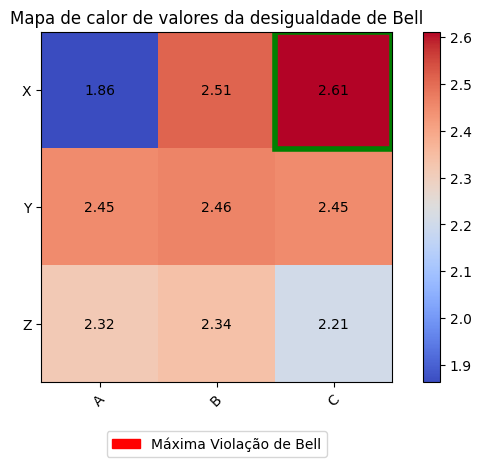

In [14]:
df = pd.DataFrame({
    'A': [Valores_S[0,0],Valores_S[1,0],Valores_S[2,0]],
    'B': [Valores_S[0,1],Valores_S[1,1],Valores_S[2,1]],
    'C': [Valores_S[0,2],Valores_S[1,2],Valores_S[2,2]]
},index = ['X', 'Y', 'Z'])

fig, ax = plt.subplots()
im = ax.imshow(df.values, cmap='coolwarm')

plt.colorbar(im)

ax.set_xticks(np.arange(len(df.columns)))
ax.set_yticks(np.arange(len(df.index)))
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.index)

plt.xticks(rotation=45)

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        valor = f"{df.iloc[i, j]:.2f}"
        cor = "white" if df.iloc[i, j] < 0.5 else "black"
        ax.text(j, i, valor, ha="center", va="center", color=cor)


max_i, max_j = np.unravel_index(np.argmax(df.values), df.shape)
rect = plt.Rectangle((max_j - 0.5, max_i - 0.5), 1, 1, edgecolor='green', facecolor='none', linewidth=4)
ax.add_patch(rect)

Max_violacao = mpatches.Patch(color='red', label='Máxima Violação de Bell')
legenda = plt.legend(handles=[Max_violacao], loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=1)
plt.title("Mapa de calor de valores da desigualdade de Bell")
plt.tight_layout()
plt.show()

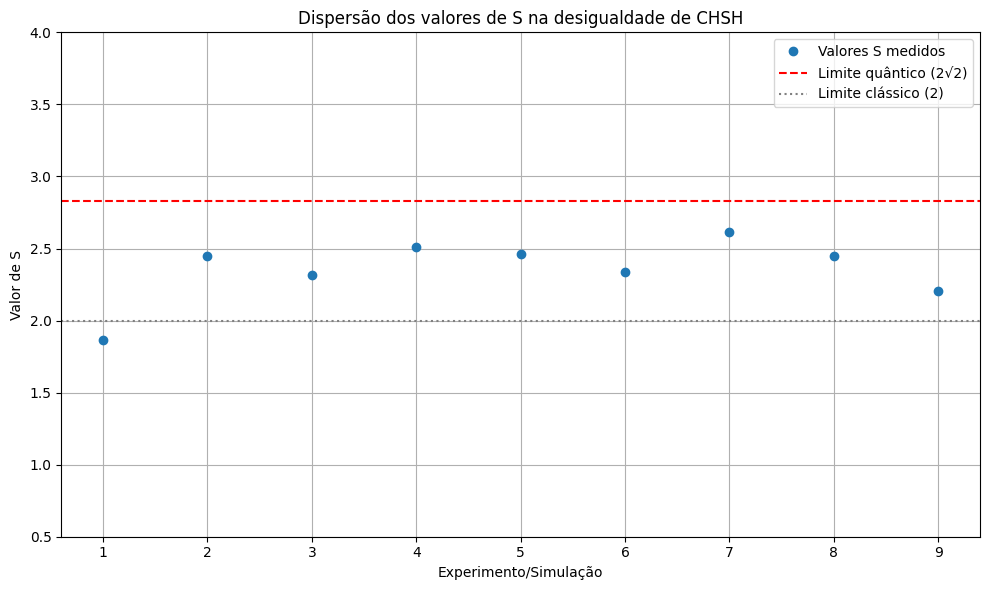

In [16]:
valores_S = [Valores_S[0,0],Valores_S[1,0],Valores_S[2,0],Valores_S[0,1],Valores_S[1,1],Valores_S[2,1],Valores_S[0,2],Valores_S[1,2],Valores_S[2,2]]
indices = list(range(1, len(valores_S)+1))

plt.figure(figsize=(10, 6))
plt.plot(indices, valores_S, marker='o', linestyle='', label='Valores S medidos')

plt.axhline(y=2*np.sqrt(2), color='red', linestyle='--', label='Limite quântico (2√2)')

plt.axhline(y=2, color='gray', linestyle=':', label='Limite clássico (2)')

plt.title('Dispersão dos valores de S na desigualdade de CHSH')
plt.xlabel('Experimento/Simulação')
plt.ylabel('Valor de S')
plt.ylim(0.5, 4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
